In [32]:
import activation_func as fn
from model import Model
from layer import Layer
from loss_func import MSE
from data_loader import DataLoader

In [33]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Dataset initialisation

In [34]:
def bytes_to_pixels(image):
    image_bytes = image['bytes']
    image_array = np.frombuffer(image_bytes, dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_GRAYSCALE)
    pixel_values = image.flatten()
    return pixel_values

In [35]:
training_data_path = 'dataset/train.parquet'
test_data_path = 'dataset/test.parquet'

In [36]:
percentage_of_dataset = 1

In [37]:
df1 = pd.read_parquet(training_data_path).rename(columns={'image.bytes': 'image'})
df2 = pd.read_parquet(test_data_path).rename(columns={'image.bytes': 'image'})

print(df1)

                                                   image  label
0      {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      5
1      {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      0
2      {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      4
3      {'bytes': b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      1
4      {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      9
...                                                  ...    ...
59995  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      8
59996  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      3
59997  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      5
59998  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      6
59999  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      8

[60000 rows x 2 columns]


In [38]:
df1['pixels'] = df1['image'].apply(bytes_to_pixels)

df2['pixels'] = df2['image'].apply(bytes_to_pixels)

df = pd.concat([df1[: int(len(df1) * percentage_of_dataset)], df2[: int(len(df2) * percentage_of_dataset)]], ignore_index=True)


print(df[['pixels', 'label']])

                                                  pixels  label
0      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      5
1      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      0
2      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      4
3      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      1
4      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      9
...                                                  ...    ...
69995  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      2
69996  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      3
69997  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      4
69998  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      5
69999  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      6

[70000 rows x 2 columns]


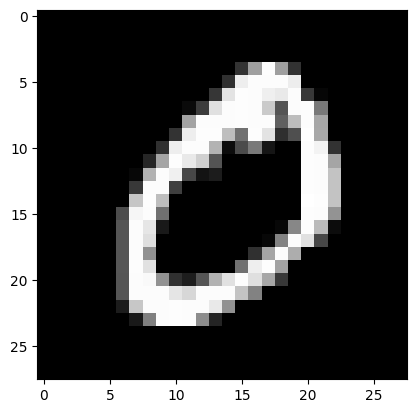

In [39]:
def draw_from_pixels(img):
    first_image_pixels = img
    image_shape = (28, 28)  

    image_array = np.array(first_image_pixels).reshape(image_shape)

    plt.imshow(image_array, cmap='gray')
    plt.show()

draw_from_pixels(df.loc[1, 'pixels'])

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder


X = df[['pixels', 'label']].copy()

y = (X.pop('label')).astype(int).values.reshape(-1, 1)

X = np.vstack(df['pixels'].values)

train_valid_size = 0.14

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=train_valid_size, 
    random_state=0, 
    shuffle=True, 
    stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, 
    test_size=train_valid_size, 
    random_state=0, 
    shuffle=True, 
    stratify=y_train
)


label_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_valid = label_encoder.transform(y_valid)
y_test = label_encoder.transform(y_test)

X_train.shape, y_train.shape

C:\Users\andrz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((51771, 784), (51771, 10))

# Discriminator training

In [41]:
discriminator = Model()

discriminator.add_layer(Layer(in_features=28*28, out_features=256, activation_function=fn.ReLU(), batch_norm_1d_size=128))
discriminator.add_layer(Layer(in_features=256, out_features=128, activation_function=fn.ReLU(), batch_norm_1d_size=128))
discriminator.add_layer(Layer(in_features=128, out_features=10, activation_function=fn.Softmax()))

In [42]:
train_loader = DataLoader(X_train, y_train, size=256)

In [43]:
learning_rate = 1e-3
input_size = X_train.shape[1]
clear_output = y_train.shape[1]

num_epochs = 1000

early_stopping_patience = 20

In [44]:
from copy import deepcopy

In [45]:
discriminator.set_learning_rate(learning_rate)

In [46]:
discriminator.train()

best_model = deepcopy(discriminator)
best_result = 10**10
no_proggress_counter = 0

for epoch in range(num_epochs):
    X_batch, y_batch = train_loader.get_batch()

    for i in range(len(X_batch)):
        y_pred = discriminator.forward(X_batch[i])
        discriminator.backward(y_batch[i])

    y_pred = discriminator.predict(X_train)
    loss = MSE(y_pred, y_train)

    no_proggress_counter += 1
    if loss < best_result:
        best_model = deepcopy(discriminator)
        best_result = loss
        no_proggress_counter = 0

    if epoch % 5 == 0:
        print(f"{epoch}: loss={loss}; best loss={best_result}")

    if no_proggress_counter == early_stopping_patience:
        print("Early stop")
        print(f"{epoch}: {best_result}")
        break


0: loss=0.09141406595574574; best loss=0.09141406595574574
5: loss=0.05023641102269737; best loss=0.035637706933373564
10: loss=0.030090204941063497; best loss=0.030090204941063497
15: loss=0.04105773496718078; best loss=0.030090204941063497
20: loss=0.024028896486449944; best loss=0.024028896486449944
25: loss=0.025728689807034827; best loss=0.024028896486449944
30: loss=0.019914624017304376; best loss=0.019914624017304376
35: loss=0.021981418168472697; best loss=0.019914624017304376
40: loss=0.019582391686465396; best loss=0.019582391686465396
45: loss=0.022595693052064294; best loss=0.017766702897111446
50: loss=0.02079928917398648; best loss=0.017766702897111446
55: loss=0.02162212863154153; best loss=0.017766702897111446
60: loss=0.019451038042543983; best loss=0.017712456593617965
65: loss=0.019493538853796913; best loss=0.01614406422643628
70: loss=0.021185605841108082; best loss=0.01614406422643628
75: loss=0.014757296555986942; best loss=0.014757296555986942
80: loss=0.0198141

## Testing

In [49]:
from sklearn.metrics import  roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


y_pred_test_score = best_model.predict(X_test)

auroc = roc_auc_score(y_test, y_pred_test_score)


y_true_flat = np.argmax(y_test, axis=1)
y_pred_flat = np.argmax(y_pred_test_score, axis=1)

accuracy = accuracy_score(y_true_flat, y_pred_flat)
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
classification_rep = classification_report(y_true_flat, y_pred_flat)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)
print(f"AUROC: {100 * auroc:.2f}%")

Accuracy: 0.9289868380777472
Confusion Matrix:
[[ 905    1   17    2    6   13   11    1   10    0]
 [   0 1087    6    1    0    3    2    1    3    0]
 [   1    3  928    9   10    2    7    5   13    1]
 [   0    8   18  908    1   26    3    2   21   13]
 [   0    0    7    0  931    0    5    0    1   11]
 [   6    3    6    5   16  819   15    1    5    8]
 [   2    1    7    0   13   12  927    0    1    0]
 [   0   11   21    4   27    2    0  928    8   20]
 [   3   23   26    9   12   20   12    2  843    6]
 [   4    9    4   11   94    9    1    7    6  829]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       966
           1       0.95      0.99      0.97      1103
           2       0.89      0.95      0.92       979
           3       0.96      0.91      0.93      1000
           4       0.84      0.97      0.90       955
           5       0.90      0.93      0.92       884
           6       0

In [50]:
path = 'models/discriminator1.pickle'
best_model.save(path)